In [73]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy.stats import binned_statistic
from scipy.special import erf
from scipy.optimize import curve_fit
import math
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory


In [4]:
feats = h5py.File('/cosma5/data/dp004/dc-cues1/features/halo_features_s99','r+')    

In [22]:
nbins= 15
bins = np.logspace(np.log10(np.min(feats['M200c'])),np.log10(np.max(feats['M200c'])), nbins+1)

Text(0.5,0,'$M_{200c}$')

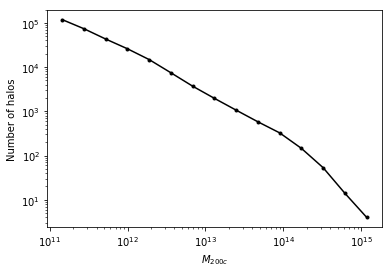

In [23]:
mass_func, edges = np.histogram(feats['M200c'], bins=bins)
plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='black', marker='o',markersize=3)

plt.ylabel('Number of halos')
plt.xlabel(r'$M_{200c}$')


In [24]:
# Compare number of subhalos with number of galaxies

ngals, edges, _ = binned_statistic(feats['M200c'], feats['Ngals'], statistic = 'mean',
                                     bins=bins)
ngals_error, edges, _ = binned_statistic(feats['M200c'], feats['Ngals'], statistic = 'std',
                                     bins=bins)


In [25]:

nsats, edges, _ = binned_statistic(feats['M200c'], feats['Ngals'][:]-1, statistic = 'mean',
                                     bins=bins)
nsats_error, edges, _ = binned_statistic(feats['M200c'], feats['Ngals'][:]-1, statistic = 'std',
                                     bins=bins)

In [26]:
central = feats['Ngals'][:] > 0

ncen, edges, _ = binned_statistic(feats['M200c'], central, statistic = 'mean',
                                     bins=bins)
ncen_error, edges, _ = binned_statistic(feats['M200c'], central, statistic = 'std',
                                     bins=bins)

In [135]:
def n_centrals(logMhalo, logMmin, sigmaM):
    return 0.5 * (1 + erf((logMhalo - logMmin)/sigmaM))

def n_satellites(Mhalo, Mcut, M1, alpha):

    #Mcut = 10**logMcut
    #M1 = 10**logM1
    return ((Mhalo - Mcut)/M1)**alpha

In [136]:
popt_cen, pcov = curve_fit(n_centrals, np.log10((edges[1:]+edges[:-1])/2.), ncen,
                          p0 = [11., 0.2])

popt_sats, pcov = curve_fit(n_satellites, ((edges[1:]+edges[:-1])/2.), nsats,
                           p0 = [12., 13., 1.])

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [137]:
m_fit = np.linspace(np.min(feats['M200c']), np.max(feats['M200c']),100)

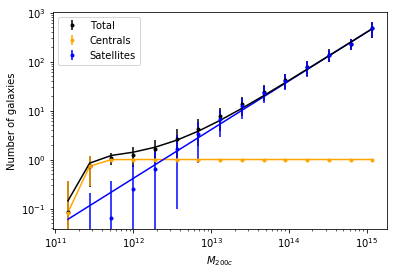

In [138]:
fig = plt.figure()
ax = plt.axes()
ax.errorbar((edges[1:]+edges[:-1])/2.,
           ngals, yerr = ngals_error, 
             color='black', marker='o',markersize=3,
            linestyle = '', label  = 'Total')

ax.errorbar((edges[1:]+edges[:-1])/2.,
           ncen, yerr = ncen_error, 
             color='orange', marker='o',markersize=3, label = 'Centrals',
           linestyle = '')

ax.plot((edges[1:]+edges[:-1])/2., 
        n_centrals(np.log10((edges[1:]+edges[:-1])/2.), *popt_cen), color = 'orange')

ax.errorbar((edges[1:]+edges[:-1])/2.,
           nsats, yerr = nsats_error, 
             color='blue', marker='o',markersize=3,
            label = 'Satellites',linestyle = '')

ax.plot(((edges[1:]+edges[:-1])/2.),
        n_satellites(((edges[1:]+edges[:-1])/2.), *popt_sats), color = 'blue')


ax.plot(((edges[1:]+edges[:-1])/2.),
        n_satellites(((edges[1:]+edges[:-1])/2.), *popt_sats) + n_centrals(np.log10((edges[1:]+edges[:-1])/2.), *popt_cen),
        color = 'black')


ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

In [142]:
feats.close()